*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [1]:
# import libraries
# deep learning
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
print(tf.__version__)

# basic operations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# nlp
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
import re
import string

# machine learning
from scipy.sparse import csr_matrix
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV

2.4.1
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2021-04-06 10:11:06--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv          [ <=>                ] 349.84K  --.-KB/s    in 0.04s   

2021-04-06 10:11:06 (7.95 MB/s) - ‘train-data.tsv’ saved [358233]

--2021-04-06 10:11:07--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv          [ <=>                ]

In [3]:
train_data = pd.read_csv(train_file_path, sep='\t', header=None, names=['Class', 'Text'])
test_data = pd.read_csv(test_file_path, sep='\t', header=None, names=['Class', 'Text'])

In [4]:
train_data.head()

,Class,Text
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [5]:
train_data.shape

(4179, 2)

In [6]:
print('Number of instances of each class in TRAIN DATA:')
print(train_data['Class'].value_counts())

Number of instances of each class in TRAIN DATA:
ham     3619
spam     560
Name: Class, dtype: int64


In [7]:
# lower case
train_data['Text'] = train_data['Text'].map(lambda x: x.lower())

In [8]:
# remove numbers
train_data['Text'] = train_data['Text'].map(lambda x: re.sub(r'\d', '', x))

In [9]:
# remove punctuation
train_data['Text'] = train_data['Text'].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [10]:
# remove white spaces at begining or ending
train_data['Text'] = train_data['Text'].map(lambda x: x.strip())

In [11]:
# stop words removal and tokenization
stop_words = list(map(lambda x: x.translate(str.maketrans('', '', string.punctuation)), set(stopwords.words('english'))))  # remove punctuation from stopwords

train_data['Tokens'] = train_data['Text'].map(lambda x: word_tokenize(x))
train_data['Tokens'] = train_data['Tokens'].map(lambda x: [i for i in x if not i in stop_words])

In [12]:
train_data.head()

,Class,Text,Tokens
0,ham,ahhhhjust woken uphad a bad dream about u thos...,"[ahhhhjust, woken, uphad, bad, dream, u, thoso..."
1,ham,you can never do nothing,"[never, nothing]"
2,ham,now u sound like manky scouse boy stevelike i ...,"[u, sound, like, manky, scouse, boy, stevelike..."
3,ham,mum say we wan to go then go then she can shun...,"[mum, say, wan, go, go, shun, bian, watch, da,..."
4,ham,never y lei i v lazy got wat dat day ü send me...,"[never, lei, v, lazy, got, wat, dat, day, ü, s..."


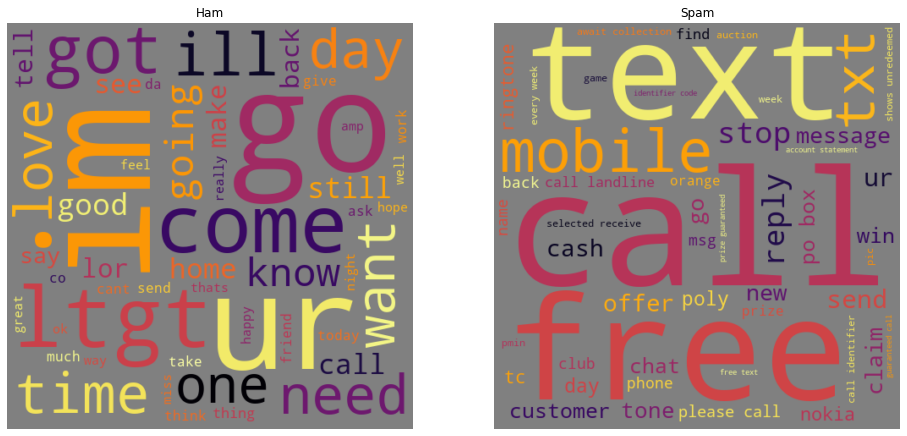

In [13]:
# word cloud for each class
text_ham = ''
text_spam = ''

for i in train_data.iterrows():
  if i[1]['Class'] == 'ham':
    text_ham += ' '.join(i[1]['Tokens'])
  else:
    text_spam += ' '.join(i[1]['Tokens'])

w_cloud_ham = WordCloud(width=480, 
                    height=480,
                    margin=10,
                    background_color="gray",
                    colormap='inferno',
                    max_words=50).generate(text_ham)

w_cloud_spam = WordCloud(width=480, 
                    height=480,
                    margin=10,
                    background_color="gray",
                    colormap='inferno',
                    max_words=50).generate(text_spam)


f, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].imshow(w_cloud_ham, interpolation='bilinear')
ax[0].axis('off')
ax[0].title.set_text('Ham')

ax[1].imshow(w_cloud_spam, interpolation='bilinear')
ax[1].axis('off')
ax[1].title.set_text('Spam')

plt.show()

First approach: bag of words and SVM

In [14]:
# get the vocabulary
vocabulary = []

for i in train_data['Tokens']:
  vocabulary += i
vocabulary = sorted(list(set(vocabulary)))

In [15]:
def featurize_tokens(tokens):
  """
    Creates a sparse matrix containing the frequency of each word of the vocabulary
    from the tokens in each document (message). A blank column is added at the
    end of the matrix in case there is an unknown word in the test dataset.
  """
  out = np.zeros((len(tokens), len(vocabulary)+1))

  row_idx = 0

  for doc in tokens:
    freqs = {i:doc.count(i) for i in doc}

    for word, freq in freqs.items():
      try:
        col_idx = vocabulary.index(word)
      except:
        col_idx = len(vocabulary)  # in case a word doesn't exist in the vocabulary

      out[row_idx, col_idx] = freq

    row_idx += 1

  return csr_matrix(out)

In [16]:
# featurize train data
X_train = featurize_tokens(train_data['Tokens'])

In [17]:
# search for the best params to train SVM
clf = SVC(probability=True, random_state=123)
parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'C':[0.3, 1, 10]}

svm_model = GridSearchCV(clf, parameters)
svm_model.fit(X_train, train_data['Class'])

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=123, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.3, 1, 10],
                         'kernel': ('linear', 'rbf', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [18]:
print("Best parameters:", svm_model.best_params_)
print("Score:", svm_model.best_score_)

Best parameters: {'C': 0.3, 'kernel': 'linear'}
Score: 0.9808583789359082


In [19]:
# transform test data
test_data['Text'] = test_data['Text'].map(lambda x: x.lower())\
.map(lambda x: re.sub(r'\d', '', x))\
.map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))\
.map(lambda x: x.strip())

test_data['Tokens'] = test_data['Text'].map(lambda x: word_tokenize(x)).map(lambda x: [i for i in x if not i in stop_words])

test_data.head()

,Class,Text,Tokens
0,ham,i am in hospital da i will return home in eve...,"[hospital, da, return, home, evening]"
1,ham,not much just some textin how bout you,"[much, textin, bout]"
2,ham,i probably wont eat at all today i think im go...,"[probably, eat, today, think, im, gon, na, pop..."
3,ham,don‘t give a flying monkeys wot they think and...,"[‘, give, flying, monkeys, wot, think, certain..."
4,ham,who are you seeing,[seeing]


In [20]:
# featurize test data
X_test = featurize_tokens(test_data['Tokens'])

In [21]:
# performance
print("ACCURACY:", svm_model.score(X_test, test_data['Class']))
print("AUROC:", roc_auc_score(test_data['Class'], svm_model.predict_proba(X_test)[:, 1]))

ACCURACY: 0.9827586206896551
AUROC: 0.9916191448288104


The results are really good but let's try a deep learning approach

In [27]:
# create the model
rnn_model = keras.Sequential()
rnn_model.add(Input(shape=(1,), dtype='string'))  # the input is going to be the message

In [28]:
# add layer to transform the words to integers
max_tokens = len(vocabulary)
max_len = 32
vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_len
)

vectorize_layer.adapt(np.array(train_data['Tokens'].map(lambda x: ' '.join(x))))

rnn_model.add(vectorize_layer)

In [29]:
# add rest of layers
rnn_model.add(Embedding(input_dim=len(vocabulary)+1, output_dim=32))
rnn_model.add(LSTM(64))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dense(1, activation='sigmoid'))

In [30]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 32)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 32, 32)            231456    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 258,401
Trainable params: 258,401
Non-trainable params: 0
_________________________________________________________________


In [31]:
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [32]:
# encode the classes: ham -> 0, spam -> 1
enc = OrdinalEncoder(categories=[['ham', 'spam']])
train_data['Class_'] = enc.fit_transform(np.array(train_data['Class']).reshape(-1,1))

In [33]:
# train the model
history = rnn_model.fit(
    np.array(train_data['Tokens'].map(lambda x: ' '.join(x))), np.array(train_data['Class_']),
    epochs=20,
    validation_split=0.2
)

Epoch 1/20
105/105 [==============================] - 6s 36ms/step - loss: 0.4359 - accuracy: 0.8830 - auc: 0.6485 - val_loss: 0.1161 - val_accuracy: 0.9737 - val_auc: 0.9778
Epoch 2/20
105/105 [==============================] - 3s 28ms/step - loss: 0.0624 - accuracy: 0.9871 - auc: 0.9863 - val_loss: 0.0730 - val_accuracy: 0.9701 - val_auc: 0.9936
Epoch 3/20
105/105 [==============================] - 3s 28ms/step - loss: 0.0163 - accuracy: 0.9979 - auc: 0.9962 - val_loss: 0.0810 - val_accuracy: 0.9761 - val_auc: 0.9837
Epoch 4/20
105/105 [==============================] - 3s 26ms/step - loss: 0.0101 - accuracy: 0.9978 - auc: 0.9973 - val_loss: 0.0863 - val_accuracy: 0.9761 - val_auc: 0.9802
Epoch 5/20
105/105 [==============================] - 3s 28ms/step - loss: 0.0128 - accuracy: 0.9958 - auc: 0.9998 - val_loss: 0.1379 - val_accuracy: 0.9749 - val_auc: 0.9688
Epoch 6/20
105/105 [==============================] - 3s 28ms/step - loss: 0.0050 - accuracy: 0.9991 - auc: 0.9993 - val_loss

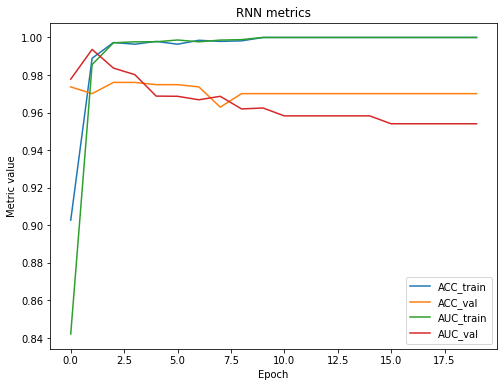

In [34]:
plt.figure(figsize=(8,6))
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='ACC_train')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='ACC_val')
plt.plot(range(len(history.history['auc'])), history.history['auc'], label='AUC_train')
plt.plot(range(len(history.history['val_auc'])), history.history['val_auc'], label='AUC_val')

plt.title('RNN metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.legend()
plt.show()

In [35]:
# tranform test data
test_data['Class_'] = enc.transform(np.array(test_data['Class']).reshape(-1,1))

In [36]:
# model performance
rnn_model.evaluate(
    np.array(test_data['Tokens'].map(lambda x: ' '.join(x))), np.array(test_data['Class_'])
)

44/44 [==============================] - 0s 7ms/step - loss: 0.1948 - accuracy: 0.9806 - auc: 0.9422


[0.19478736817836761, 0.9806034564971924, 0.9421727657318115]

The SVM seems to give a better performance and it is simpler than a RNN so we are going to use the SVM.

In [37]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  tokens = [i for i in word_tokenize(re.sub(r'\d', '', pred_text.lower()).translate(str.maketrans('', '', string.punctuation)).strip()) if not i in stop_words]
  m = featurize_tokens([tokens])
  pred = svm_model.predict_proba(m)

  if pred[0,1] <= 0.5:
    label = 'ham'
  else:
    label = 'spam'
  
  prediction = [float(pred[0,1]), label]

  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[0.011210482543626674, 'ham']


In [38]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
